In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../')
sys.path.append(root)

import math

from pmd_beamphysics import single_particle

DISTGEN_INPUT_FILE = os.path.join(root, 'templates/sectormagnet/distgen.in.yaml')

This notebook implements the automated generation of a single sectorbend lattice in GPT.  This is accomplished using `gpt.Sectormagnet`.  The beam here is effectively a single particle at 10 MeV/c momentum, and is created using distgen.  See the doc string for details of this object:

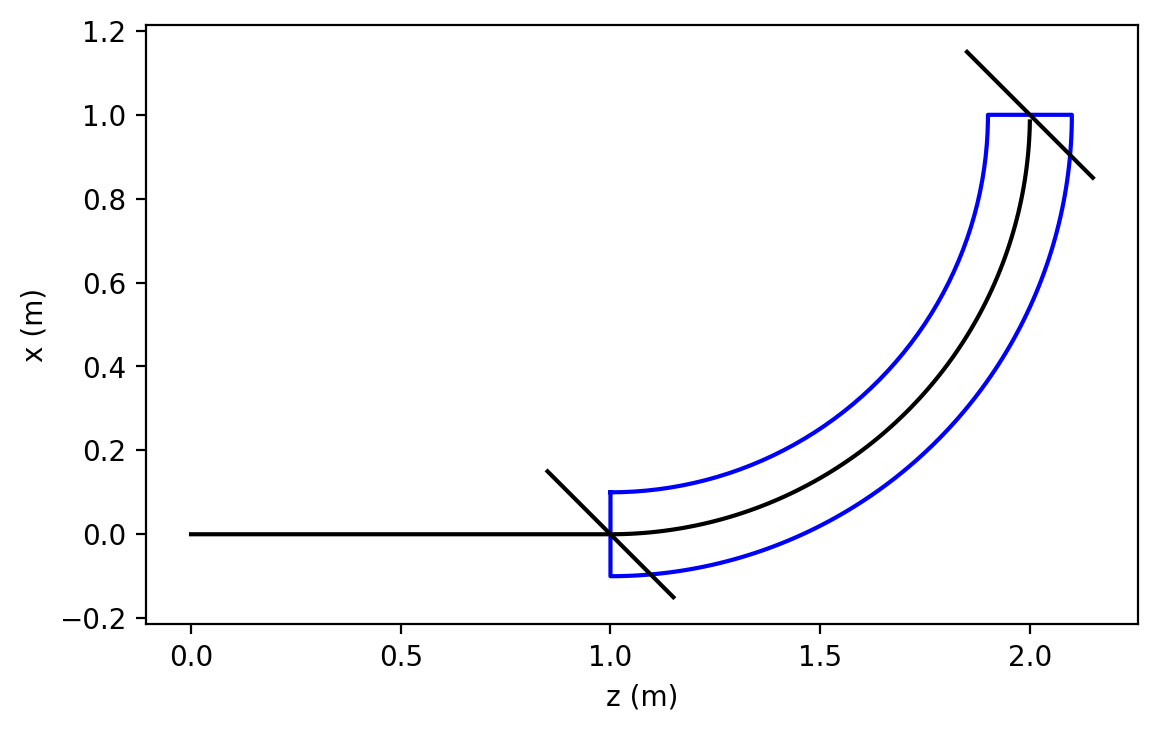

In [2]:
import numpy as np
from distgen import Generator
gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen.run()
pg = gen.particles

angle=90
R=1
p = np.mean(pg['p'])

from gpt.lattice import Lattice
from gpt.bstatic import Sectormagnet
from gpt.element import Screen


lat = Lattice('Single Bend')
lat.add(Sectormagnet('b1', 1.0, +angle, p, phi_in=45, phi_out=45, color='b'), ds=1)
lat.plot_floor();

Here the beam starts at the blue dot and the sectormagnet is set to have pole face edges that make it a rectangular bend, as is shown with the black liness for the pole faces.  First, the beam is created using distgen.  Then a new GPT file is made that includes autogenerated sectormagnet lines for defining the bend:

In [3]:
lat.write_gpt_lines(output_file='gpt.temp.in')

from gpt import GPT

G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.run()
print(G)


GPT object:
   Original input file: gpt.temp.in
   Template location: /Users/colwyngulliford/GitHub/lume-gpt/examples/elements
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpjfr9crss
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.030205965042114258 (sec)


To see the results, plot the orbit of the bunch overlayed on the sectormagnet plot.  This is shown below, with the orbit of the bunch computed from GPT show in light blue.

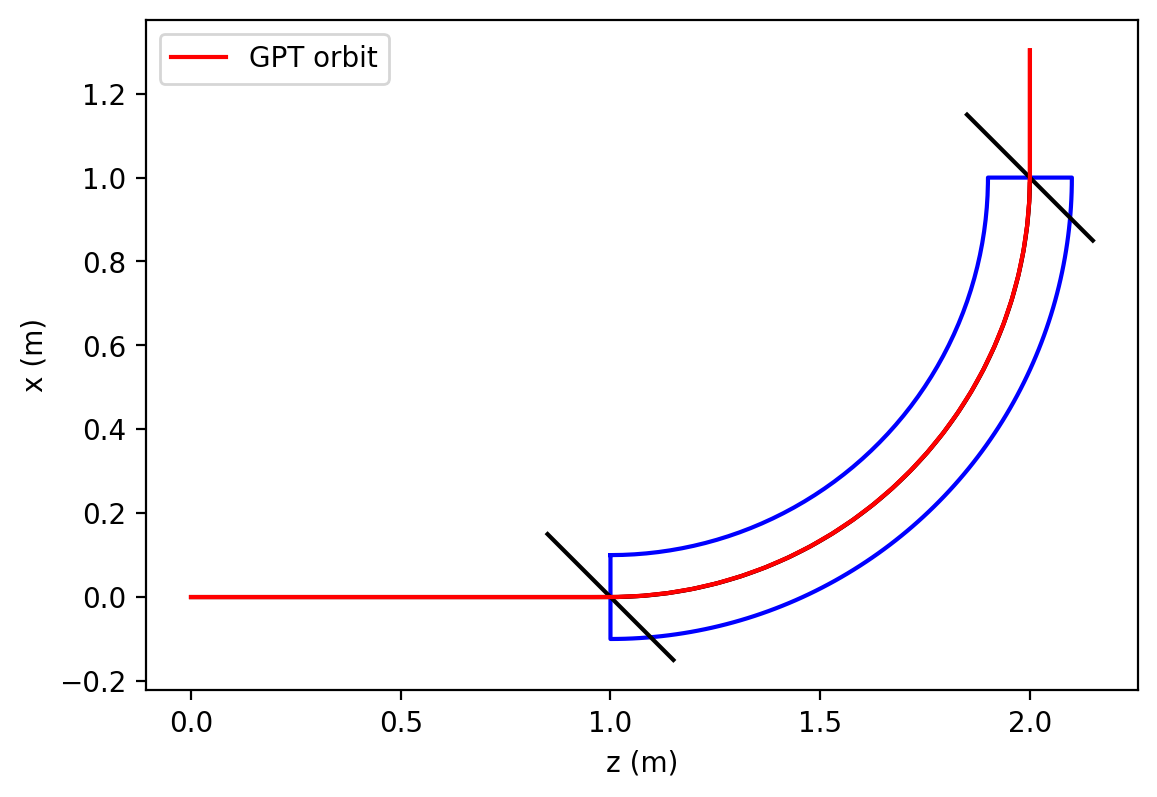

In [4]:
from matplotlib import pyplot as plt
plt.plot(G.stat('mean_z')[:-1], G.stat('mean_x')[:-1], 'r')
lat.plot_floor(axis='equal')
plt.plot(G.stat('mean_z')[:-1], G.stat('mean_x')[:-1], 'r')

plt.gca().set_aspect('equal')
plt.legend(['GPT orbit']);

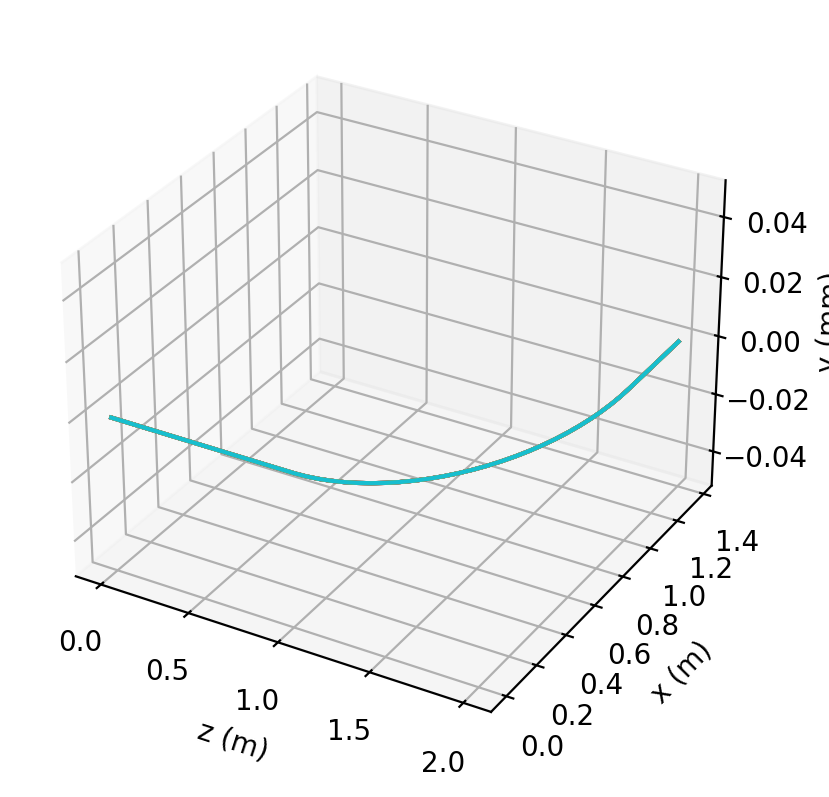

In [5]:
from mpl_toolkits.mplot3d import Axes3D

t1 = G.trajectory(1, data_type='tout')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

legend = []

for ii in range(0,70):
    
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        ax.plot(tii['x'], tii['y']*1000, tii['z'], zdir='x')

ax.set_xlabel('z (m)');
ax.set_ylabel('x (m)');
ax.set_zlabel('y (mm)');

# Weak focusing
Here a similar magnet is set up to demonstrate the effect of weak focusing in a dipole.  For a pure sectormagnet weak focusing will naturally create a focus at the exit of a 90 deg bend.

In [6]:
from distgen.physical_constants import unit_registry

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen['x_dist']={'type':'uniform', 'min_x': -0.1*unit_registry('m'), 'max_x': +0.1*unit_registry('m')}
gen['n_particle']=100
gen.run()
pg = gen.particles

lat = Lattice('Single Bend')
R = 1
p = pg['mean_pz']

lat.add(Sectormagnet('b1', 1.0, +angle, p, color='b', width=0.3), ds=1)
lat.write_gpt_lines(output_file='gpt.temp.in')

G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.run()
#print(G)

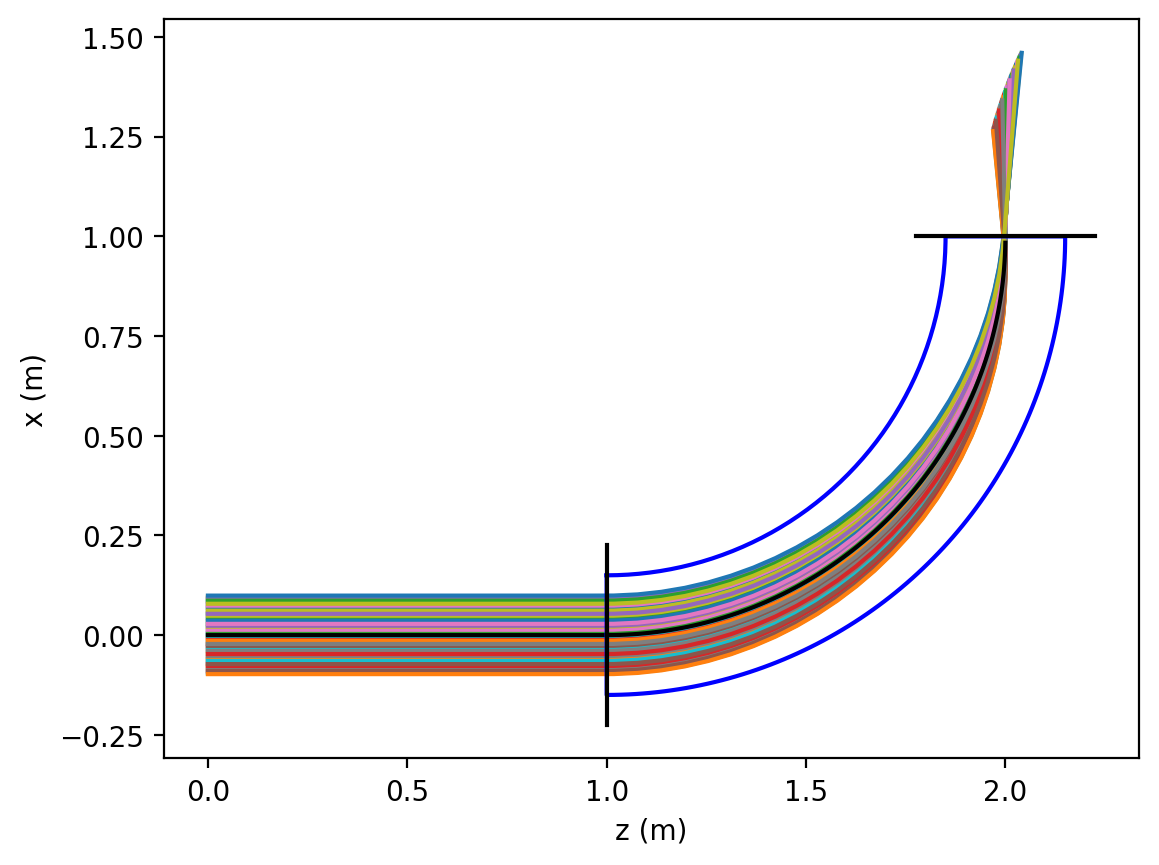

In [7]:
t1 = G.trajectory(1, data_type='tout')
fig = plt.figure()
ax = fig.add_subplot(111)

legend = []

for ii in range(0,70):
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        plt.plot(tii['z'], tii['x'])

plt.xlabel('z (m)');
plt.ylabel('x (m)');
lat.plot_floor(axis='equal');

# Edge Focusing
Here a sector magent with non-zero pole face rotation angles is simulated.

In [8]:
from gpt import GPT
from distgen.physical_constants import unit_registry

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen['x_dist']={'type':'uniform', 'min_x': -0.15*unit_registry('m'), 'max_x': +0.15*unit_registry('m')}
gen['n_particle']=100
gen.run()
pg = gen.particles


lat1 = Lattice('L1')
lat1.add(Sectormagnet('b1', R, 90, p, phi_in=-45, phi_out=-45, width=0.4), ds=1)

lat2 = Lattice('L2')
lat2.add(Sectormagnet('b2', R, 90, p, phi_in=+45, phi_out=+45, width=0.4), ds=1)

lat3 = Lattice('L2')
lat3.add(Sectormagnet('b2', R, -90, p, phi_in=-45, phi_out=-45, width=0.4),ds=1)

lat4 = Lattice('L2')
lat4.add(Sectormagnet('b2', R, -90, p, phi_in=+45, phi_out=+45, width=0.4),ds=1)

lat1.write_gpt_lines(output_file='gpt.temp.in')
G1 = GPT(input_file='gpt.temp.in', initial_particles=pg)
G1.run()

lat2.write_gpt_lines(output_file='gpt.temp.in')
G2 = GPT(input_file='gpt.temp.in', initial_particles=pg)
G2.run()

lat3.write_gpt_lines(output_file='gpt.temp.in')
G3 = GPT(input_file='gpt.temp.in', initial_particles=pg)
G3.run()

lat4.write_gpt_lines(output_file='gpt.temp.in')
G4 = GPT(input_file='gpt.temp.in', initial_particles=pg)
G4.run()


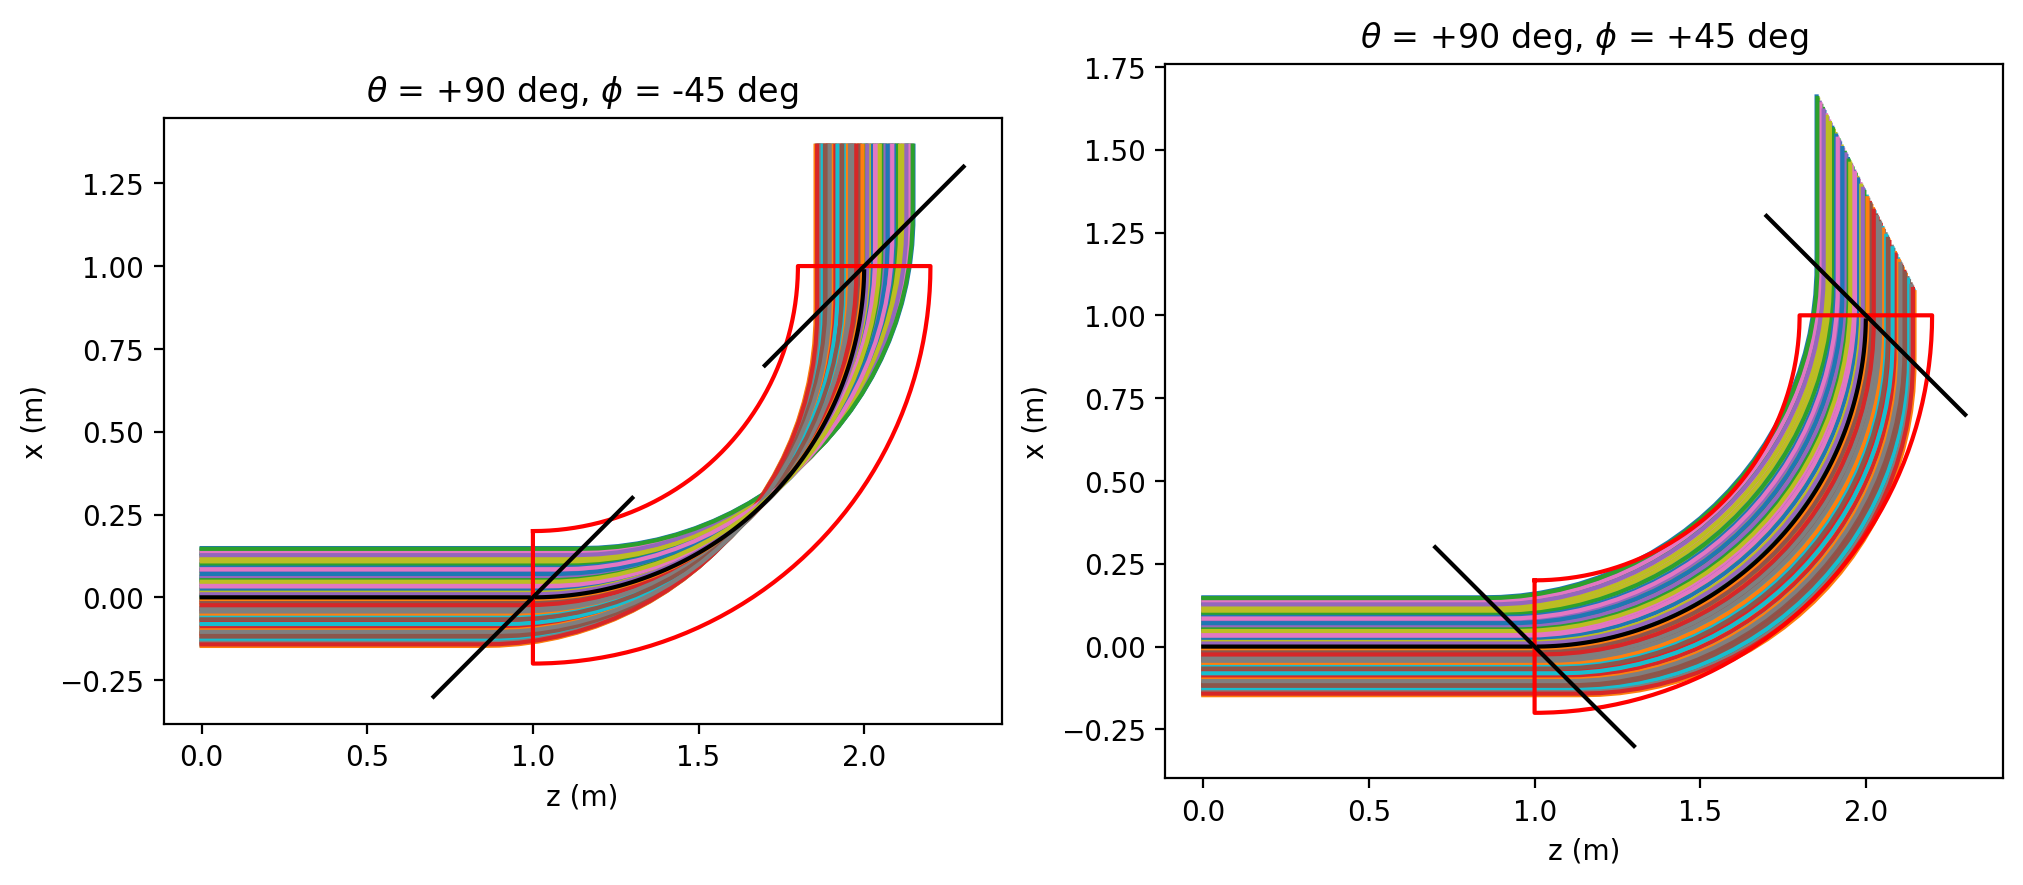

In [9]:
fig, ax = plt.subplots(1, 2,constrained_layout=True, figsize=[10,10])

for ii in range(0, gen['n_particle']):
    tii = G1.trajectory(ii, data_type='tout')
    if(tii):
        ax[0].plot(tii['z'], tii['x'])

lat1.plot_floor(axis='equal', ax=ax[0])
ax[0].set_title(r'$\theta$ = +90 deg, $\phi$ = -45 deg');

for ii in range(0, gen['n_particle']):
    tii = G2.trajectory(ii, data_type='tout')
    if(tii):
        ax[1].plot(tii['z'], tii['x'])
        
lat2.plot_floor(axis='equal', ax=ax[1])
ax[1].set_title(r'$\theta$ = +90 deg, $\phi$ = +45 deg');

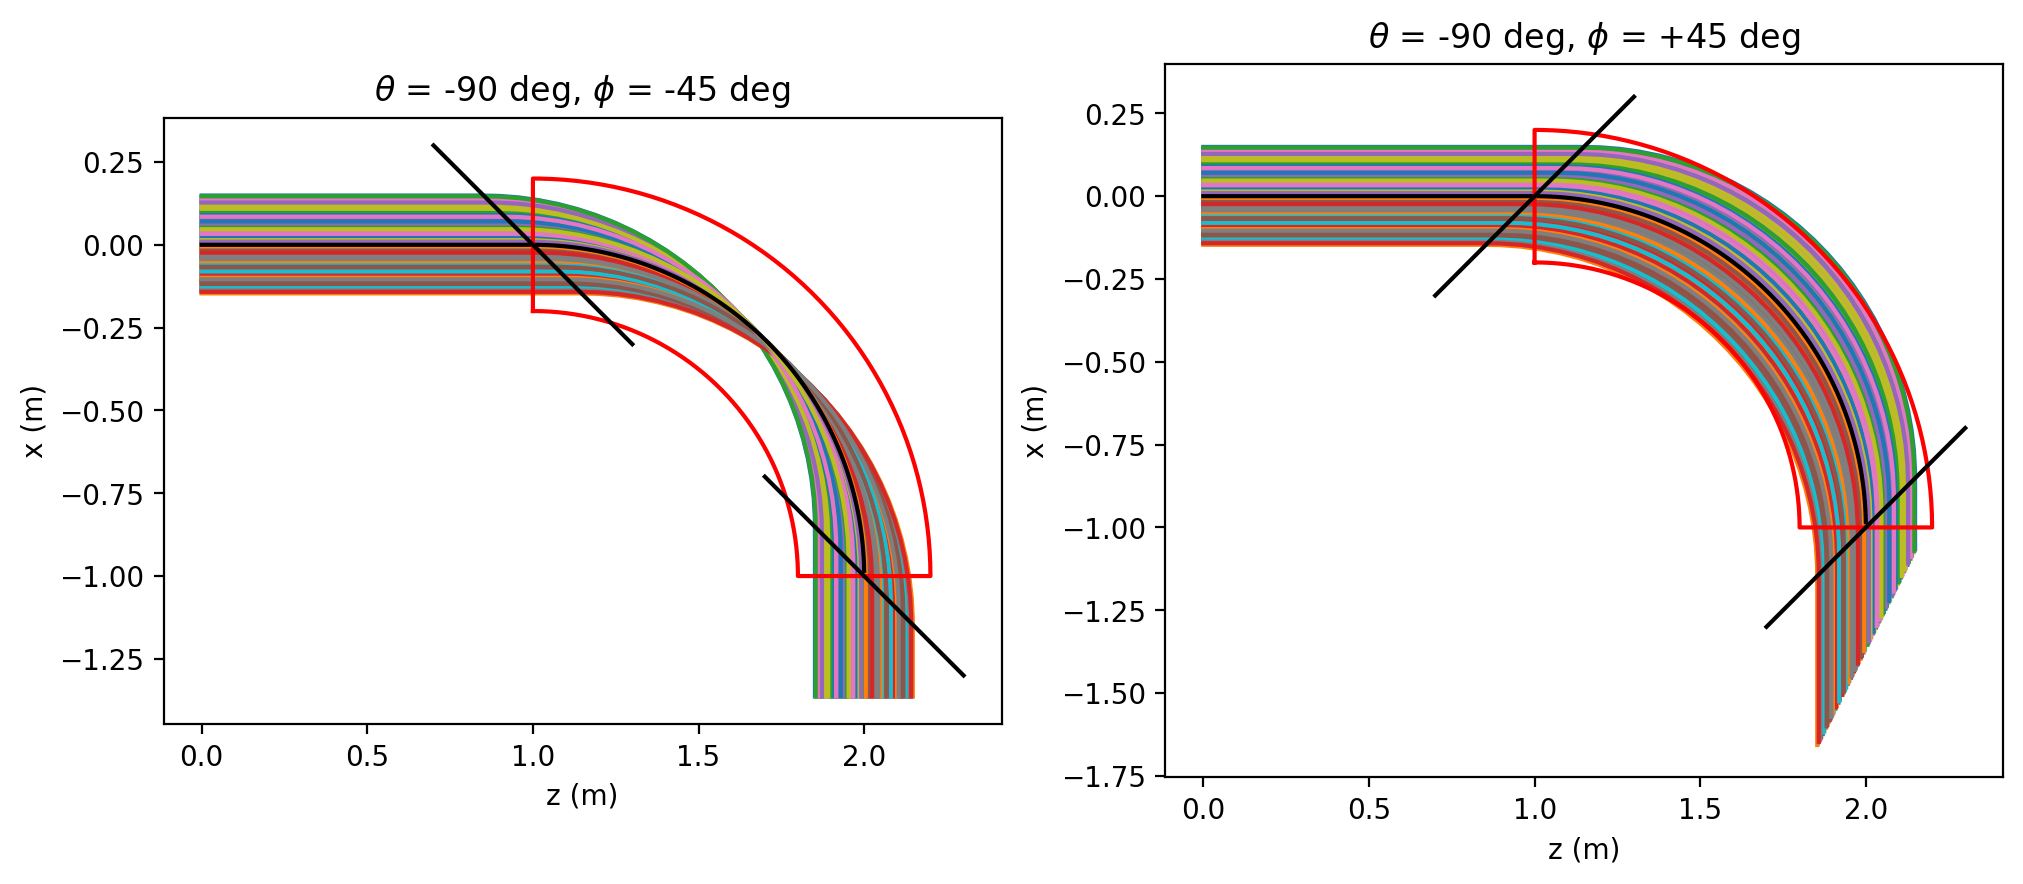

In [10]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=[10,10])

for ii in range(0, gen['n_particle']):
    tii = G3.trajectory(ii, data_type='tout')
    if(tii):
        ax[0].plot(tii['z'], tii['x'])

lat3.plot_floor(axis='equal', ax=ax[0])
ax[0].set_title(r'$\theta$ = -90 deg, $\phi$ = -45 deg');

for ii in range(0, gen['n_particle']):
    tii = G4.trajectory(ii, data_type='tout')
    if(tii):
        ax[1].plot(tii['z'], tii['x'])
        
lat4.plot_floor(axis='equal', ax=ax[1])
ax[1].set_title(r'$\theta$ = -90 deg, $\phi$ = +45 deg');

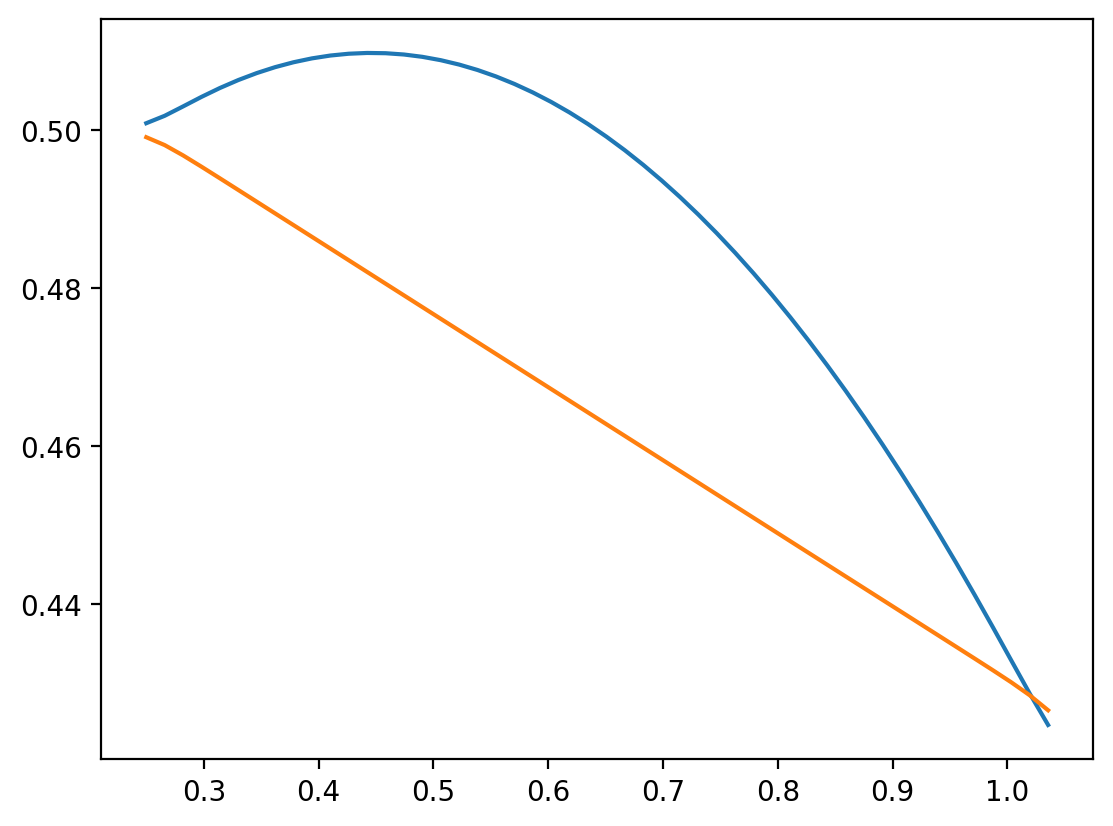

In [11]:
gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen['r_dist']={'type':'radial_uniform', 'max_r': +0.001*unit_registry('m')}
gen['n_particle']=100
gen.run()
pg = gen.particles

angle = 45

lat = Lattice('b1')
lat.add(Sectormagnet('b1', R, angle, p, phi_in=angle/4, phi_out=angle/4, width=0.2, n_screen=50, gap=0.0254),ds=0.25)

lat.write_gpt_lines(output_file='gpt.temp.in')
G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.set_variables({'Ntout':200, 'GBacc':12})
G.run()

plt.plot(lat['b1'].s_screen, G.stat('sigma_x', 'screen')*1000)
plt.plot(lat['b1'].s_screen, G.stat('sigma_y', 'screen')*1000);

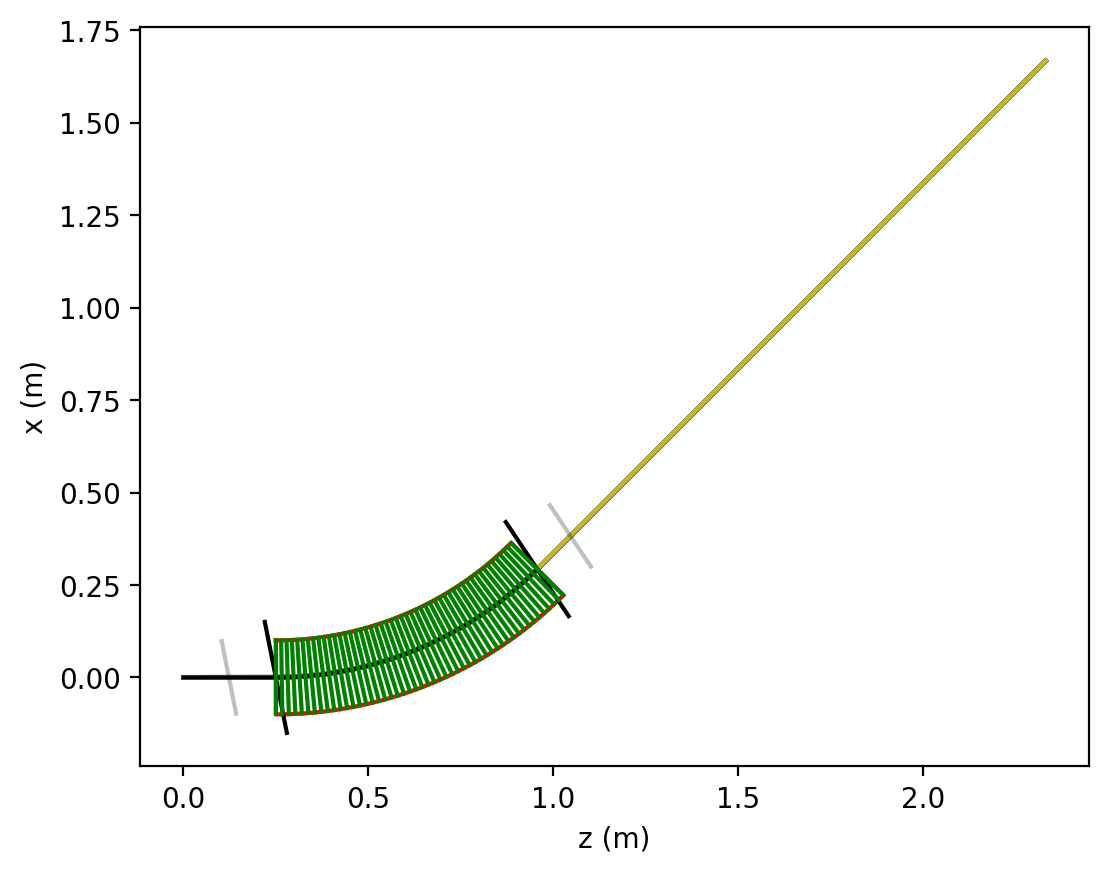

In [12]:
for ii in range(0, gen['n_particle']):
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        plt.plot(tii['z'], tii['x'])
        
lat.plot_floor();

# Fringe Field

GPT allows the user to specify 3 parameters for setting the fringe field in the sectormagnet.  These effect the on-axis field according to:

$\frac{B_y(y=0,z)}{B_0} = \frac{1}{1 + \exp\left[ b_1(z-dl) + b_2(z-dl)^2\right]}$.  Note that the $b_2$ term is a sensitive parameter and can cause strange behavior far away from the magnet.  The GPT manual recommends this term should be set to zero.  The quantity $dl$ can either be used to fine tune the bending angle computed from particle tracking or if modeling a real magnet, can be used to extend the field profile into/out of the magnet slightly.

For basic modeling of a fringe, simply specifying the dipole gap $g$ may suffice.  In this case $b_1=2/g$ and $b_2=0$.  The example below shows the fringe for a 1.5" dipole gap.

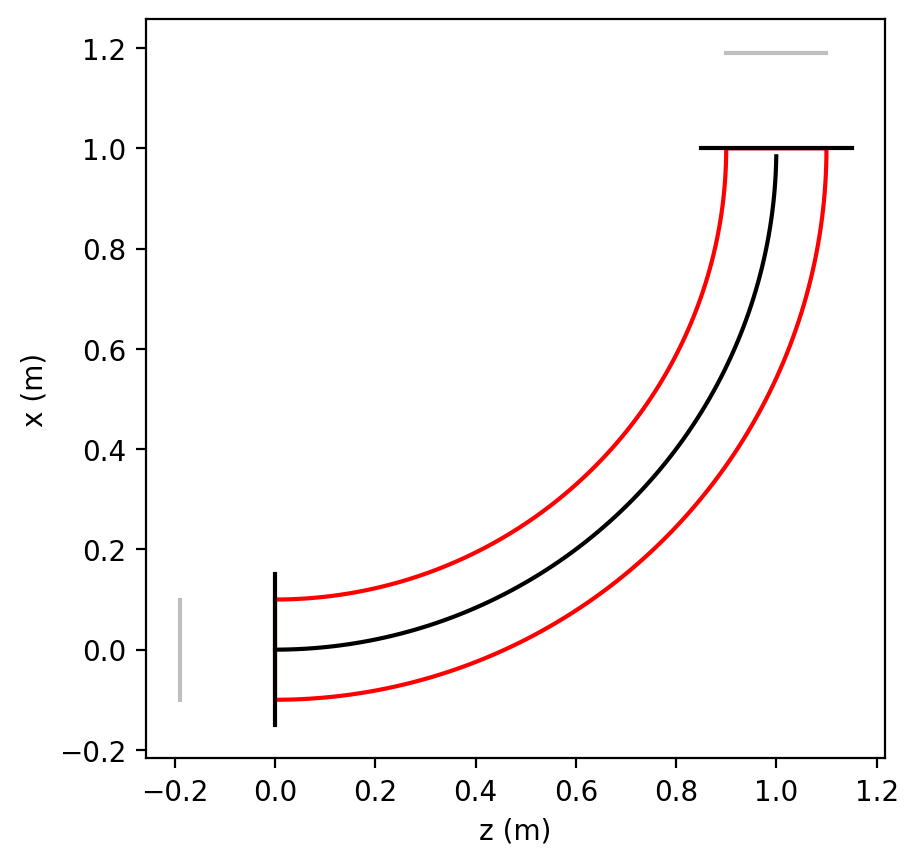

In [13]:
lat = Lattice('b1')
lat.add(Sectormagnet('b1', R, 90, p, gap=38.1e-3),ds=0)
lat.plot_floor();

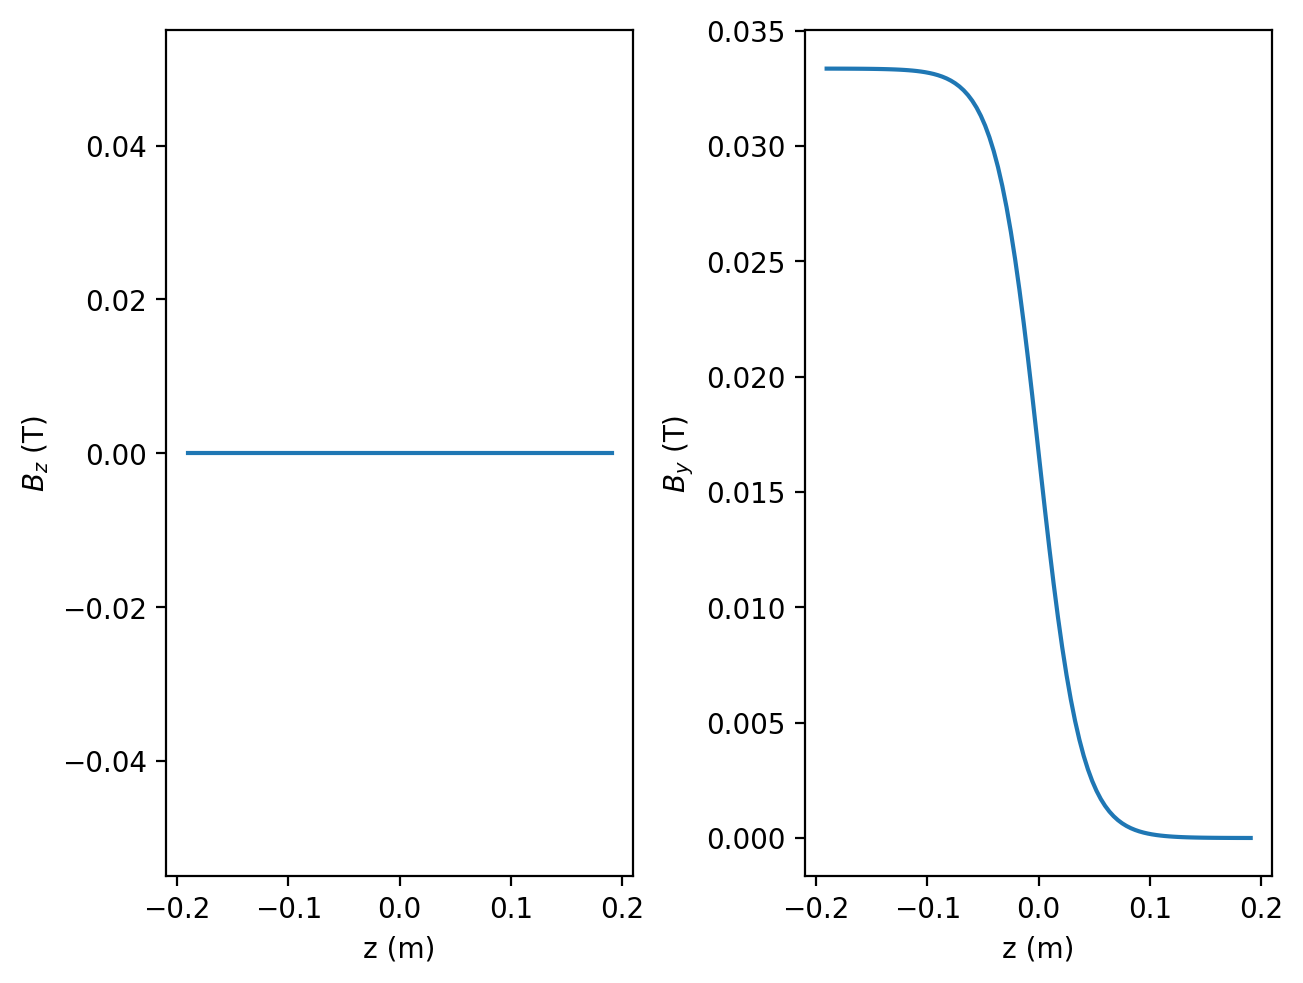

In [14]:
lat['b1'].plot_fringe()

# Autoscaling
TODO: The `Sectormagnet` class automatically set the B-field for the dipole to bend by the correct angle for the given momentum `p` assuming the sectormagnet is hard edged.  Even if the magnet in question has no fringes, particles will not leave the bend at the correct angle due to Runge-Kutta noise.  The situation is worse in the case where fringes are present.  As such, lume-GPT includes an autoscaling method to attempt fix the orbit errors by tweaking the dipole strength(s).

# Extra Screens

from distgen import Generator
from gpt.bstatic import Sectormagnet
from gpt.element import Lattice

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen.run()
pg = gen.particles

angle = 90

lat = Lattice('extra_screens')

lat.append(Sectormagnet('b1', 1.0, angle, p, n_screens=4), ds=1)
lat.write_gpt_lines(template_file=GPT_INPUT_FILE, output_file='gpt.temp.in')
lat.plot_floor();

G = GPT(input_file='gpt.temp.in', initial_particles=pg, workdir='temp', use_tempdir=False)
G.run()

plt.plot(G.stat('mean_z','tout'), G.stat('mean_x','tout'),'r');

ss = lat.s_ccs
xs = G.stat('mean_x','screen')*1000

plt.plot(ss,xs)
plt.xlabel('s (m)')
plt.ylabel('orbit x (mm)');


# Dispersion
Here the effect of dispersion is demonstrated.  First, a beam is generated with uniform relative momentum spread of $10^{-1}$ and tracked through an example bend.

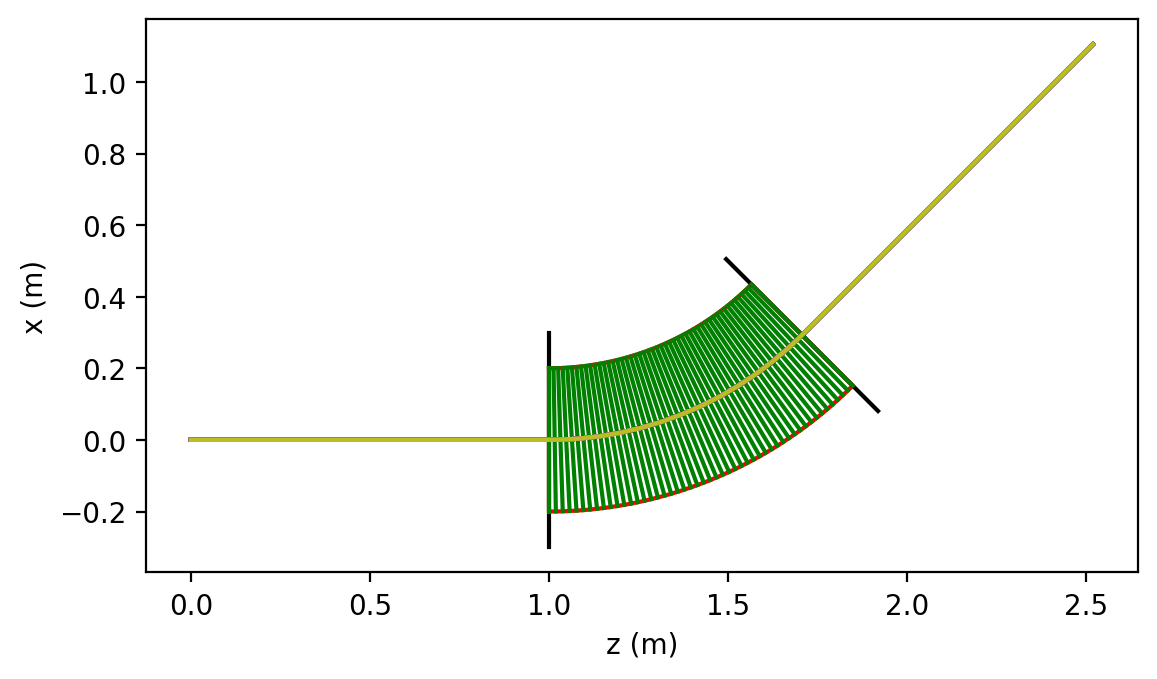

In [15]:
gen = Generator(DISTGEN_INPUT_FILE, verbose=0)

delta_pz = 1e-1
sigma_pz = delta_pz

min_pz = p*(1 - (np.sqrt(12)/2)*sigma_pz)*unit_registry('eV/c')
max_pz = p*(1 + (np.sqrt(12)/2)*sigma_pz)*unit_registry('eV/c')

gen.input['pz_dist']={'type':'uniform', 'min_pz': min_pz, 'max_pz': max_pz}

gen['n_particle']=100
gen.run()
pg = gen.particles

lat = Lattice('disp')

lat.add(Sectormagnet('b1', 1.0, angle, p, n_screen=50, width=0.4), ds=1)
lat.write_gpt_lines(output_file='gpt.temp.in')
lat.plot_floor();

G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.run()

for ii in range(0, gen['n_particle']):
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        plt.plot(tii['z'], tii['x'])
        

Using a distribution like this, it is easy to insepct if the dispersion function is closed through a section of beamline:

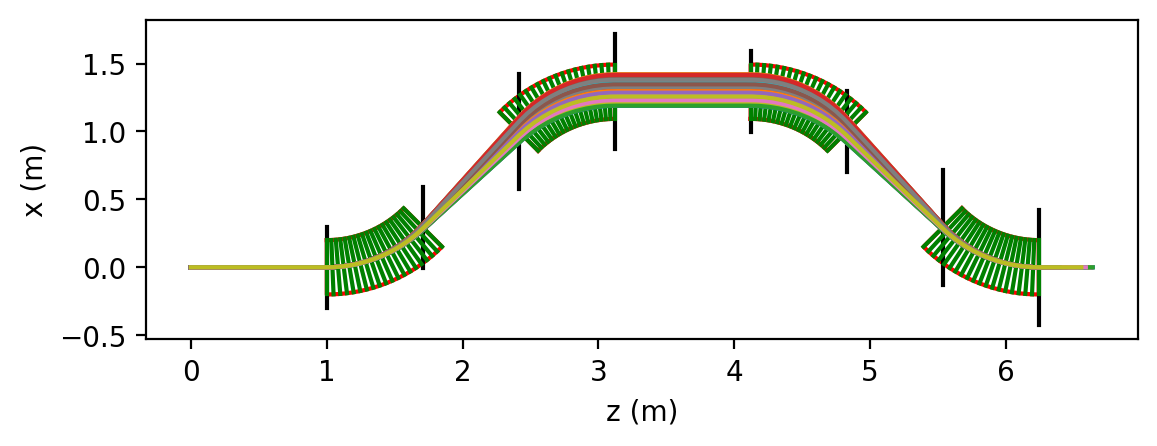

In [16]:
gen = Generator(DISTGEN_INPUT_FILE, verbose=0)

delta_pz = 3e-2
sigma_pz = delta_pz

min_pz = p*(1 - (np.sqrt(12)/2)*sigma_pz)*unit_registry('eV/c')
max_pz = p*(1 + (np.sqrt(12)/2)*sigma_pz)*unit_registry('eV/c')

gen['pz_dist']={'type':'uniform', 'min_pz': min_pz, 'max_pz': max_pz}

gen['n_particle']=100
gen.run()
pg = gen.particles

angle=45

lat = Lattice('calc disp')
lat.add(Sectormagnet('b1', 1.0, angle, p, phi_in=0, phi_out=45, n_screen=20, width=0.4), ds=1)
lat.add(Sectormagnet('b2', 1.0,-angle, p, phi_in=45, phi_out=0, n_screen=20, width=0.4), ds=1)
lat.add(Sectormagnet('b3', 1.0,-angle, p, phi_in=0, phi_out=45, n_screen=20, width=0.4), ds=1)
lat.add(Sectormagnet('b4', 1.0, angle, p, phi_in=45, phi_out=0, n_screen=20, width=0.4), ds=1)

lat.write_gpt_lines(output_file='gpt.temp.in')

tmax = 25e-9

G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.input['variables']['Ntout']=100
G.input['variables']['xacc'] = 10
G.input['variables']['GBacc'] = 10
G.input['variables']['tmax']=tmax
G.run()

lat.plot_floor()
    
for ii in range(0, gen['n_particle']):
    tii = G.trajectory(ii, data_type='tout')
    if(tii):
        plt.plot(tii['z'], tii['x'])    

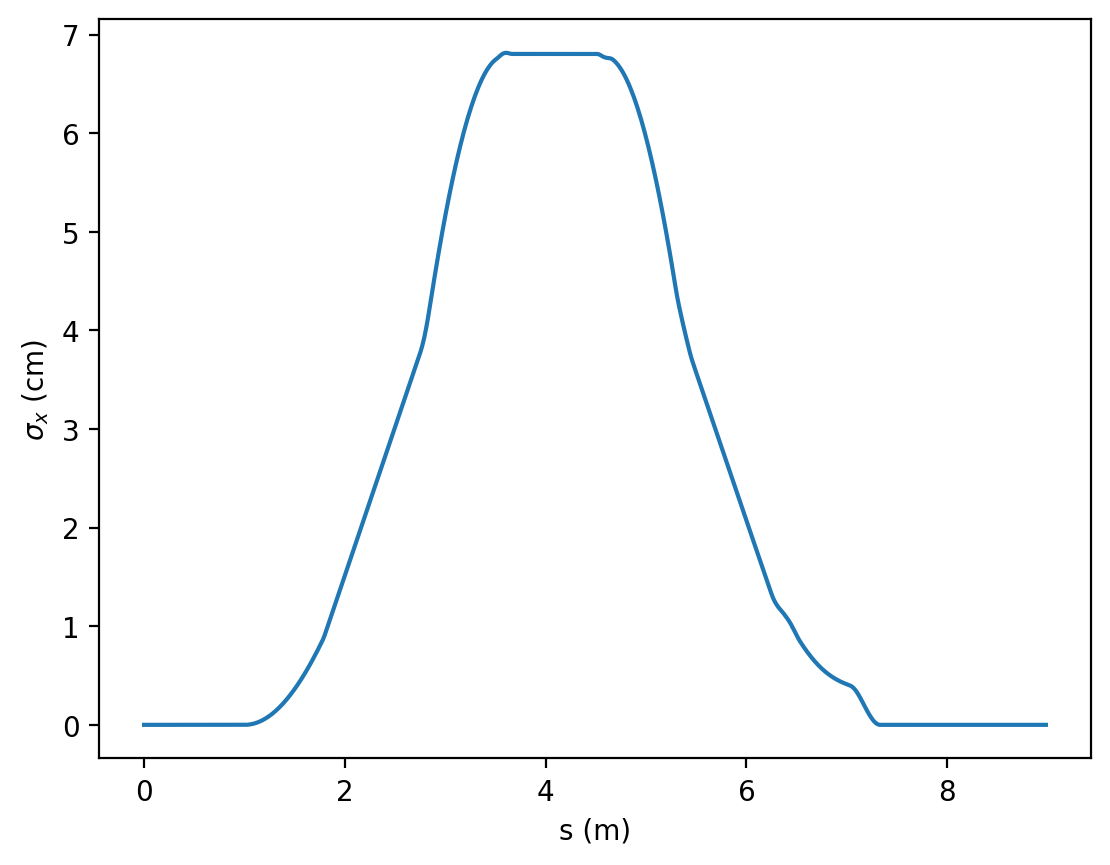

In [17]:
G = GPT(input_file='gpt.temp.in', initial_particles=pg, ref_ccs=True)
G.input['variables']['Ntout']=500
G.input['variables']['xacc'] = 10
G.input['variables']['GBacc'] = 10
G.input['variables']['tmax']=tmax*1.2
G.run()

plt.plot(3e8*G.stat('mean_t','tout'), G.stat('sigma_x','tout')*100);
plt.xlabel('s (m)')
plt.ylabel(r'$\sigma_x$ (cm)');
    
  

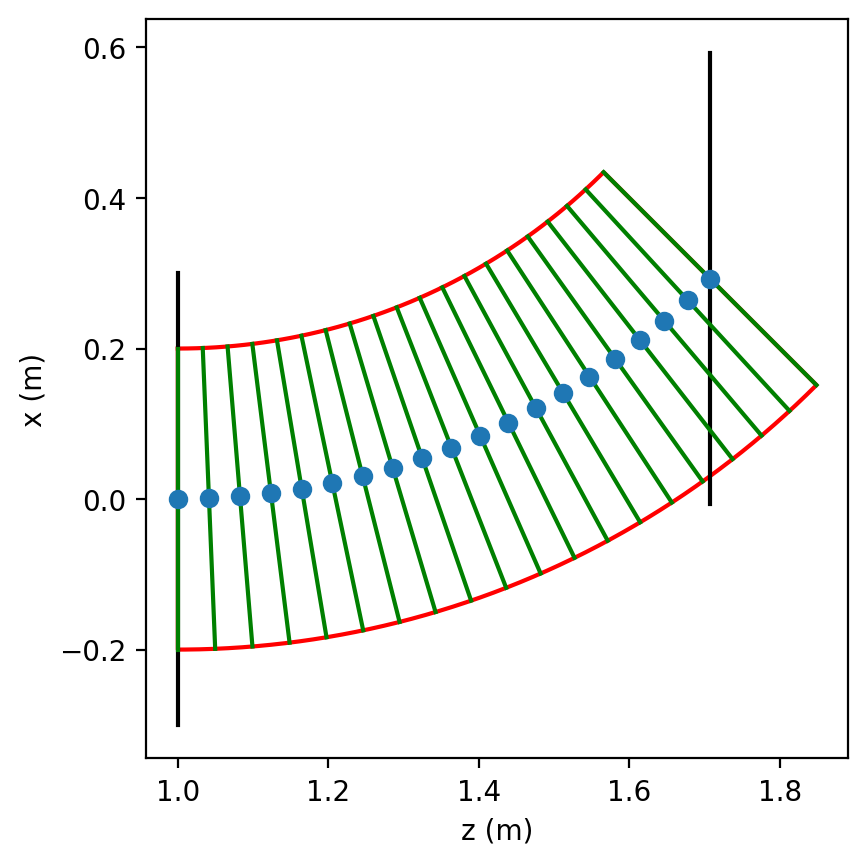

In [18]:
bend='b1'
lat[bend].plot_floor()
plt.plot(lat[bend].p_screen_center[2,:], lat[bend].p_screen_center[0,:],'o')

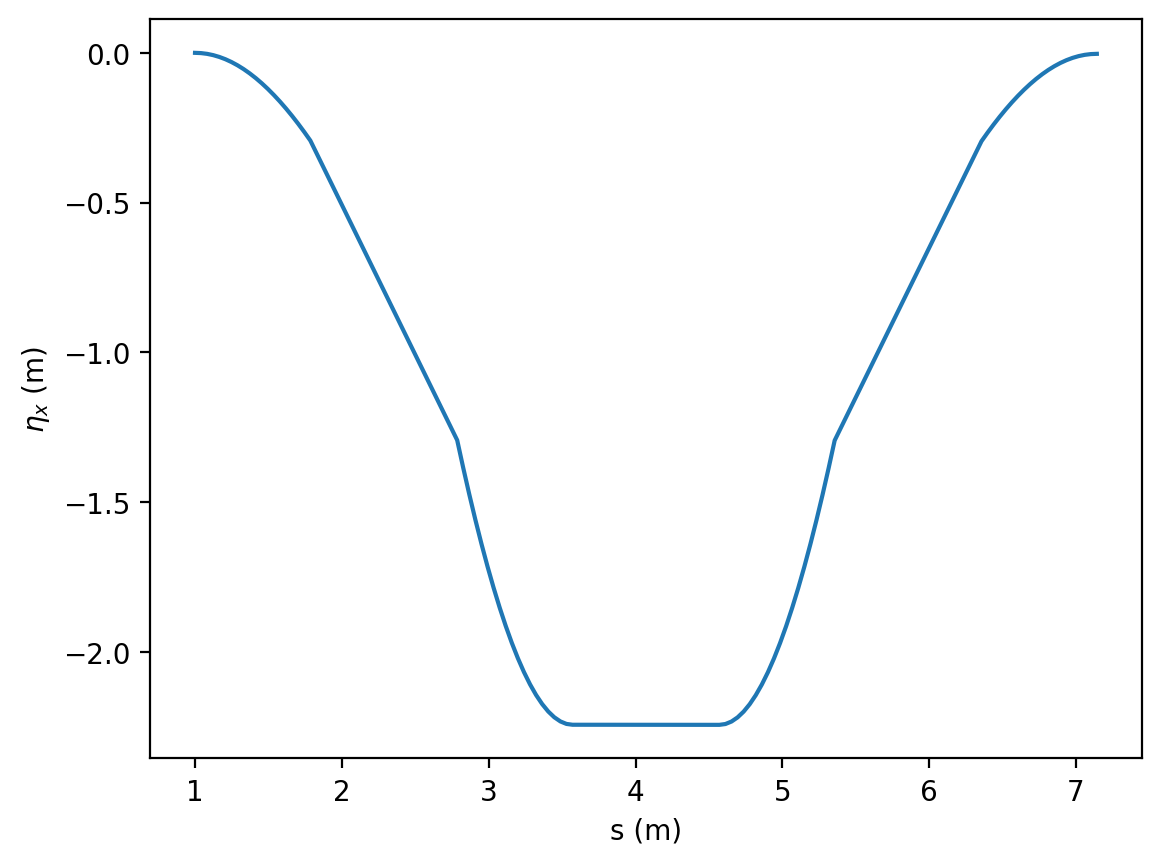

In [19]:
lat = Lattice('calc disp')
lat.add(Sectormagnet('b1', 1.0, angle, p, phi_in=0, phi_out=angle, n_screen=20, width=0.4), ds=1)
lat.add(Sectormagnet('b2', 1.0,-angle, p, phi_in=angle, phi_out=0, n_screen=20, width=0.4), ds=1)
lat.add(Sectormagnet('b3', 1.0,-angle, p, phi_in=0, phi_out=angle, n_screen=20, width=0.4), ds=1)
lat.add(Sectormagnet('b4', 1.0, angle, p, phi_in=angle, phi_out=0, n_screen=20, width=0.4), ds=1)

delta = 1e-5

lat.write_gpt_lines(output_file='gpt.temp.in')
Gp = GPT(input_file='gpt.temp.in')
Gp.set_variables({'xacc':10, 'GBacc':10, 'tmax':27e-9})
Gp.track1(pz0=p*(1+delta));

Gm = GPT(input_file='gpt.temp.in')
Gm.set_variables({'xacc':10, 'GBacc':10, 'tmax':27e-9})
Gm.track1(pz0=p*(1-delta));

etax = (Gp.stat('mean_x','screen')-Gm.stat('mean_x','screen'))/2.0/delta
s = np.concatenate((lat['b1'].s_screen, lat['b2'].s_screen, lat['b3'].s_screen, lat['b4'].s_screen))

plt.plot(s, etax);
plt.xlabel('s (m)')
plt.ylabel(r'$\eta_x$ (m)');

In [20]:
os.remove('gpt.temp.in');

# 180 Deg bend

In [21]:
angle, R, p = 10, 1, 1e6

lat = Lattice('Single Bend')
lat.add(Sectormagnet('b1', 0.5, +angle, p, phi_in=0, phi_out=angle, color='b', width=0.45), ds=0.25)
lat.add(Sectormagnet('b2', 0.5, -angle, p, phi_in=+angle, phi_out=0, color='b', width=0.45), ds=0.1)
lat.add(Sectormagnet('b3', 0.3, -90, p, phi_in=0, phi_out=0, color='b', width=0.575), ds=0.1)
lat.add(Sectormagnet('b4', 0.3, -90, p, phi_in=0, phi_out=0, color='b', width=0.575), ds=0.0)
lat.add(Sectormagnet('b5', 0.5, -angle, p, phi_in=0, phi_out=angle, color='b', width=0.5), ds=0.1)
lat.add(Sectormagnet('b6', 0.5, +angle, p, phi_in=angle, phi_out=0, color='b', width=0.5), ds=0.1)
lat.add(Screen('s1'), ds=0.25)
lat.write_gpt_lines(output_file='gpt.temp.in');

In [22]:
G1 = GPT('gpt.temp.in', initial_particles=single_particle(pz=p))
G1.set_variables({'Ntout': 300, 'tmax':1e-8});
G1.run()

G2 = GPT('gpt.temp.in', initial_particles=single_particle(pz=1.25*p))
G2.set_variables({'Ntout': 300, 'tmax':1e-8});
G2.run()

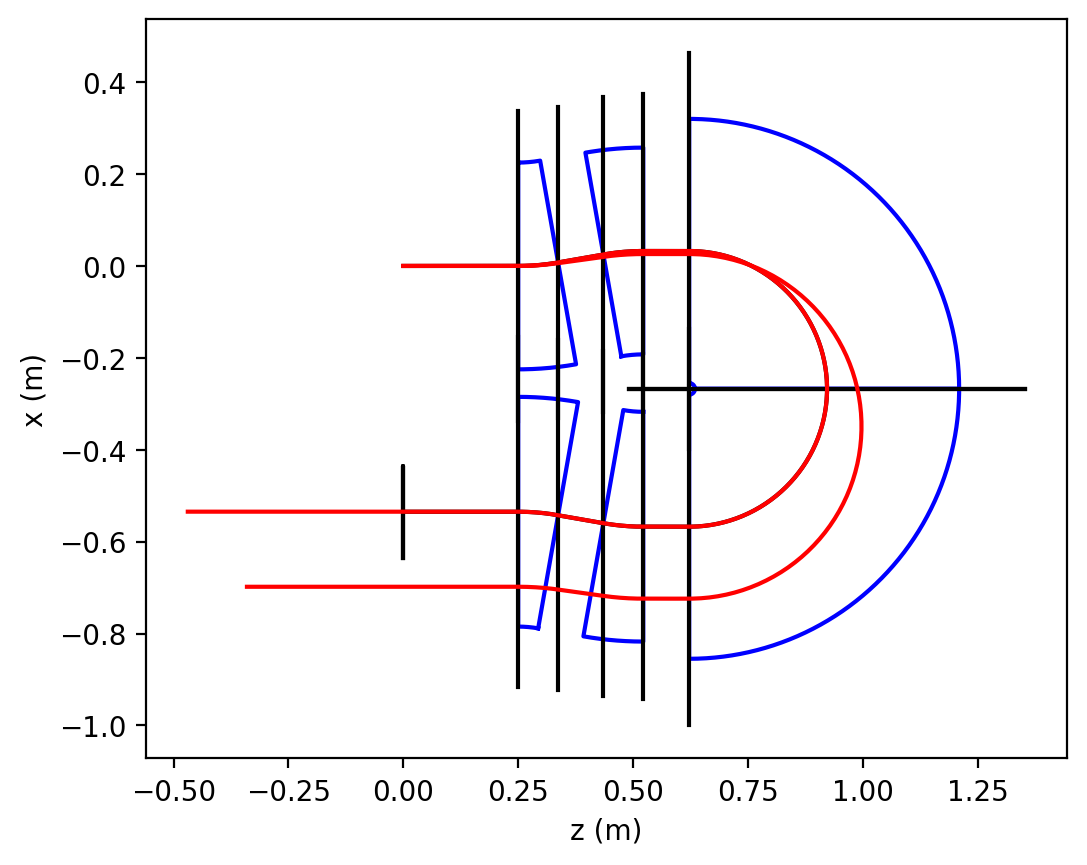

In [23]:
lat.plot_floor()
plt.plot(G1.tout_stat('mean_z'), G1.tout_stat('mean_x'), 'r');
plt.plot(G2.tout_stat('mean_z'), G2.tout_stat('mean_x'), 'r');